Javier Francisco Castilla Jiménez
* Ejercicio 3
* Práctica 1

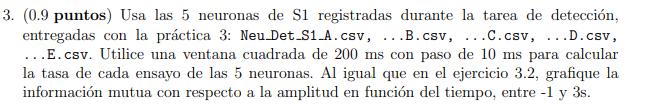

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import NeuralFunctJC as nrn
plt.style.use('Solarize_Light2')

In [3]:
neuronas=['A','B','C','D','E']
amplitudes=['0','6','8','10','12','24']
amprob={'0':0.5,'6':1/5,'8':1/5,'10':1/5,'12':1/5,'24':1/5}

In [4]:
NeuDetS1A=nrn.importar('Neu_Det_S1A.csv')
NeuDetS1B=nrn.importar('Neu_Det_S1B.csv')
NeuDetS1C=nrn.importar('Neu_Det_S1C.csv')
NeuDetS1D=nrn.importar('Neu_Det_S1D.csv')
NeuDetS1E=nrn.importar('Neu_Det_S1E.csv')
Neurons={'A':NeuDetS1A,'B':NeuDetS1B,'C':NeuDetS1C,'D':NeuDetS1D,'E':NeuDetS1E}

In [5]:
bqA=list((nrn.bloques(nrn.abrir('Neu_Det_S1A.csv'))))
bqB=list((nrn.bloques(nrn.abrir('Neu_Det_S1B.csv'))))
bqC=list((nrn.bloques(nrn.abrir('Neu_Det_S1C.csv'))))
bqD=list((nrn.bloques(nrn.abrir('Neu_Det_S1D.csv'))))
bqE=list((nrn.bloques(nrn.abrir('Neu_Det_S1E.csv'))))
bqs={'A':bqA,'B':bqB,'C':bqC,'D':bqD,'E':bqE}

In [6]:
## funciones para tasa de disparo

In [7]:
def dicneuronrate(dictneu,keyneuron,start=-1,stop=3,paso=0.01,ventana=0.2,nv=True):
    """
    Esta función crea un diccionario donde las claves son los nombres de las neuronas y los valores
    son las tasas de disparo de cada neurona. 
    keyneurons:son las claves/llaves de cada neurona. Es una lista. o tupla.
    dictneu:es un diccionario dónde las llaves son keyneurons y los valores son los 
    datos crudos de todos los ensayos de una neurona
    salida es un diccionario."""
    Tns={clave:0 for clave in keyneuron}
    bsup,nven=nrn.bordesup(start,stop,paso,ventana,nv=True) 
    func=lambda ensayo : nrn.tasa(ensayo,nventanas=nven,paso=paso,ventana=ventana,start=start)# esta función calcula la tasa de disparo de un ensayo nventanas, paso=0.01,ventana=0.05,start=-2 
    for llave in keyneuron:
        fr=map(func,dictneu[llave]) # array con las tasas de disparo para cada ventana
        Tns[llave]=np.array(list(fr))
    return Tns

In [8]:
def txclases(tasas,keyneuron,bqs):
    """tasas"""
    #tasas de disparo separadas por amplitud del estímulo en un diccionario de diccionarios
    Txclases={a:0 for a in keyneuron}
    for llave in keyneuron:
        bloques=nrn.clases(tasas[llave],bqs[llave])
        #clases={keyclases[i]:bloques[i] for i in range(len(keyclases))}
        Txclases[llave]=bloques
    return Txclases

In [9]:
def clases(tasa,bqs):
    bloques=nrn.clases(tasas,bqs)
    return bloques

In [10]:
## Tasa de disparo por clases.

In [11]:
Tns1=dicneuronrate(Neurons,neuronas)
txclas=txclases(Tns1,neuronas,bqs)

In [13]:
len(txclas['A'][0][0])# número de ventanas, nv

381

In [58]:
## funciones para Información mutua

In [59]:
#bins para un set de datos
def dbines(datos,nbins=20):
    m,M=(np.min(np.array(datos).flatten()),np.max(np.array(datos).flatten()))#busco min y max de un set de datos #mínimo y máximo
    bins=np.linspace(round(m)-1,round(M)+1,nbins+1)#cálculo de bins
    return bins

In [60]:
def I_dprob(datos,dbines,keyest,keytotal='dtotal'):
    AG=dict()
    nv=len(datos[0][0])
    for i in range(len(keyest)):
        pvamp=[]
        for v in range(nv):    
            counts, bins=np.histogram(datos[i][:,v],bins=dbines) #count guarda un array con la frecuencia y bins un array con los bordes de bins
            counts=counts/counts.sum()#cálculo de distribución de probabilidad #convertimos la frecuencia en probabilidad (frecuencia relativa)
            pvamp.append(counts)
        AG.update({keyest[i]:np.array(pvamp)})
    #calculamos bines y probabilidades de la ddistribución total:
    #total=np.concatenate(tuple(datos)) # todas las tasas de disparo sin estar condicionadas a un tipo de estímulo
    pvtotales=[]
    for v in range(nv):
        total=np.vstack(tuple(datos))[:,v]
        counts, bins=np.histogram(total,bins=dbines) #count guarda un array con la frecuencia y bins un array con los bordes de bins
        counts=counts/counts.sum()#cálculo de distribución de probabilidad de la tasa de disparo #convertimos la frecuencia en probabilidad
        pvtotales.append(counts)
    AG.update({keytotal:pvtotales})#
    return AG

In [61]:
def I_shanonxv(ptasa,pcondicionada,ps,v):
    """
    esta es una función auxiliar para calculara I mutua de una sola ventana
    data es los datos correspondientes a una neurona, 
    total= es la llave que uso para las probabilidades de tasa totales de una neurona, es decir,las no condicionadas a ningún estímulo 
    ps=probabilidad de aparición del estímulo
    ptasa=probabilidad de la tasa
    pcondicionada= probabilidad de la tasa condicionada al estímulo
    v: ventana"""
    with np.errstate(divide='ignore',invalid='ignore'):
        Info_stim=np.nansum(pcondicionada[v]*np.log2(pcondicionada[v]/ptasa[v]))
        Ish=ps*Info_stim
    return Ish

In [20]:
def I_shanon(prob,keysest,ps,keytotal='dtotal'):
    """
    prob=son los datos de probabilidades correspondientes a un set de datos
    keysest=son las llaves de las condiciones
    ps=probabilidad de aparición del estímulo
    ptasa=probabilidad de la tasa
    pcondicionada= probabilidad de la tasa condicionada al estímulo
    """
    nv=len(prob[keysest[0]])
    ptasa=prob[keytotal]# array
    Itotal_v=[]
    for llave in keysest:
        pcondicionada=prob[llave]#array
        shanoncv=np.zeros(nv)
        for v in range(nv):
            Is=I_shanonxv(ptasa,pcondicionada,ps[llave],v)
            shanoncv[v]=Is
        Itotal_v.append(shanoncv)
    I_v=np.sum(np.stack(Itotal_v),axis=0)
    return I_v

In [68]:
def informacion(datos,bqs,keyest,ps,nbins=20,keytotal='dtotal'):
    dbins=dbines(datos,nbins)
    datxcla=nrn.clases(datos,bqs)
    prob=I_dprob(datxcla,dbins,keyest,keytotal)
    Info=I_shanon(prob,keyest,ps,keytotal)
    return Info

In [22]:
## info mutua

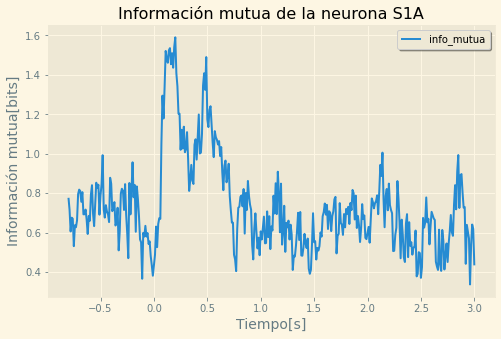

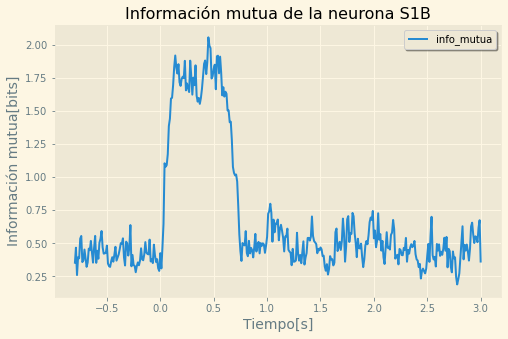

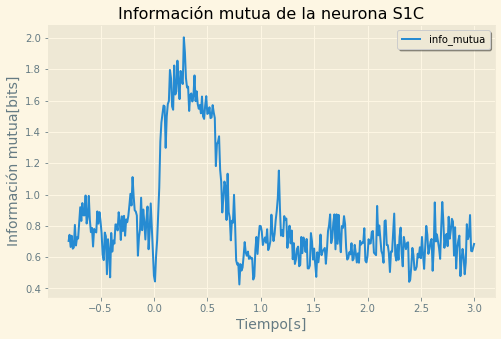

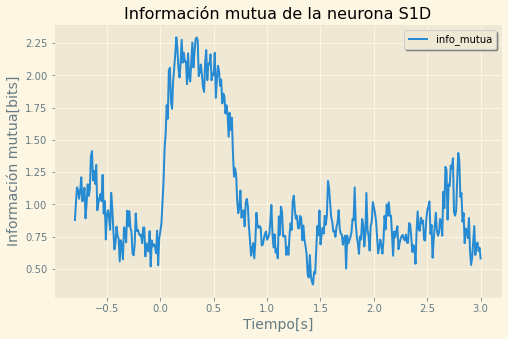

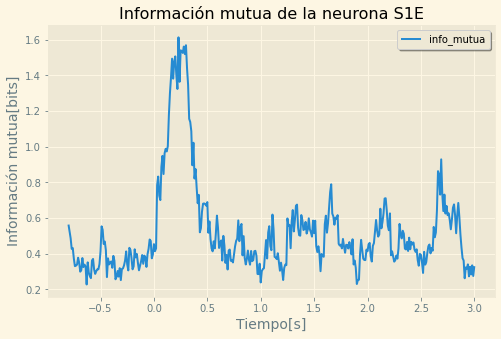

In [163]:
shanon=dict()
bsup,nven=nrn.bordesup(start=-1,stop=3,paso=0.01,ventana=0.2,nv=True) 
for llave in neuronas:
    #bins=dbines(Tns1[llave])
    #probas=I_dprob(txclas[llave],bins,amplitudes)
    #Ishanon=I_shanon(probas,amplitudes,ps=amprob)
    Ishanon=informacion(Tns1[llave],bqs[llave],amplitudes,ps=amprob)
    shanon.update({llave:Ishanon})
    ######## Figura
    fig = plt.figure(figsize=(8,5))
    plt.plot(bsup,Ishanon,label='info_mutua')
    plt.xlabel("Tiempo[s]",fontsize=14)
    plt.ylabel("Información mutua[bits]",fontsize=14)
    plt.title("Información mutua de la neurona S1"+llave)
    plt.legend(fontsize="medium",shadow=True,fancybox=True)
    plt.show()

In [157]:
def permutacion(data,nperm=1000):
    """
    esta función permuta los datos de las tasa de disparo de una neurona y guarda 
    en una lista las permutaciones donde cada elemento de las lista es una permutación 
    de los datos
    """
    forma=data.shape
    ndat=forma[0]*forma[1]
    aplana=data.flatten()
    permutaciones=[aplana[np.random.permutation(ndat)].reshape(forma) for i in range(nperm)]
    return permutaciones

In [158]:
def info_permutada(data,bqs,condiciones,pc,nperm=1000,bines=20):
    pr_information=[]
    permutaciones=permutacion(data,nperm)
    for b in range(nperm):
        pr_information.append(informacion(permutaciones[b],bqs,condiciones,pc,bines))
    pr_information=np.vstack(pr_information)
    return pr_information

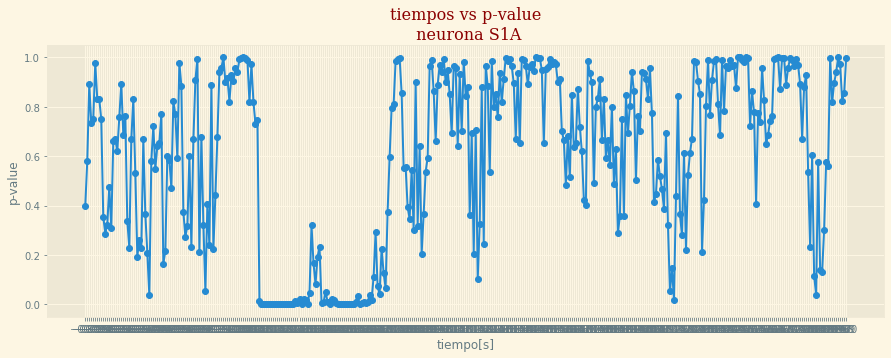

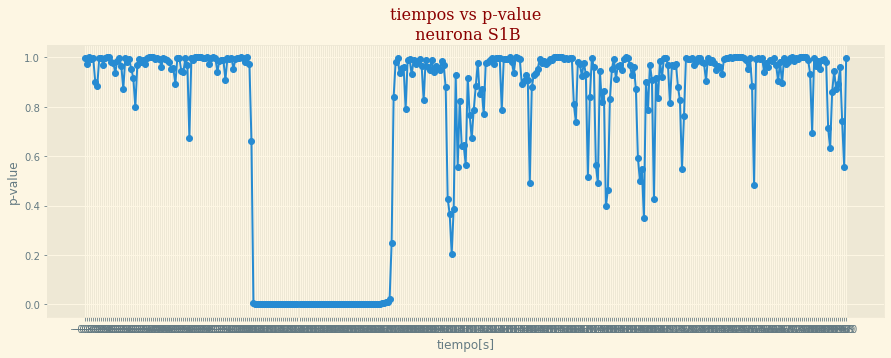

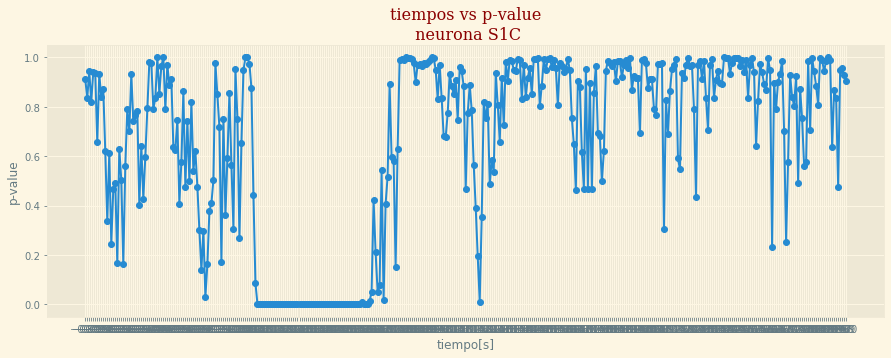

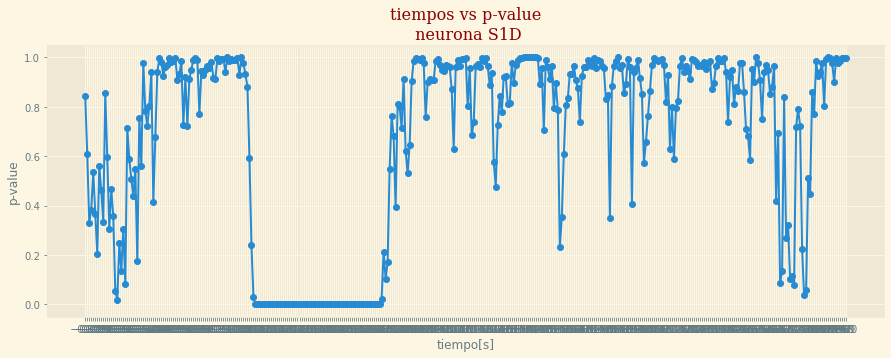

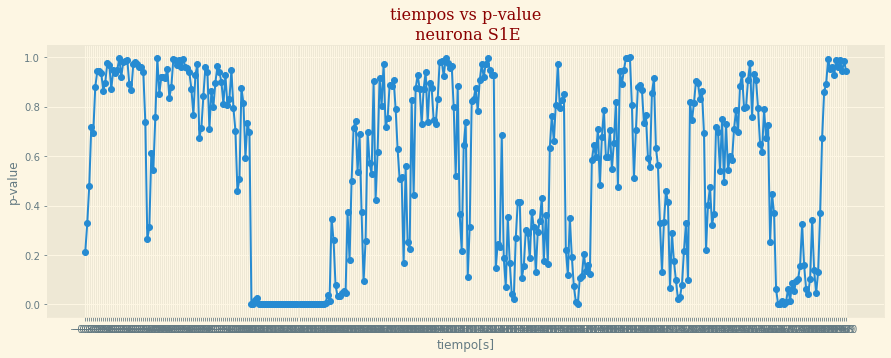

In [161]:
bsup,nven=nrn.bordesup(start=-1,stop=3,paso=0.01,ventana=0.2,nv=True) 
pes=dict()
for llave in neuronas:
    #Ishanon=informacion(Tns1[llave],bqs[llave],amplitudes,ps=amprob)
    i_real=informacion(Tns1[llave],bqs[llave],amplitudes,amprob)
    i_permutada=info_permutada(Tns1[llave],bqs[llave],amplitudes,amprob)
    p=np.sum(i_permutada>i_real,axis=0)/len(i_permutada)
    pes.update({llave:p})
    fontdict_title = {'family': 'serif','color':  'darkred','weight': 'normal','size': 16,} # formato para el título
    fig,(ax1)=plt.subplots(nrows=1,ncols=1,sharex=False,figsize=(15,5))
    ax1.scatter(bsup,p)
    ax1.plot(bsup,p)
    ax1.set_ylabel('p-value')
    ax1.set_xlabel('tiempo[s]')
    ax1.set_title('tiempos vs p-value\n neurona S1'+llave, fontdict_title) 

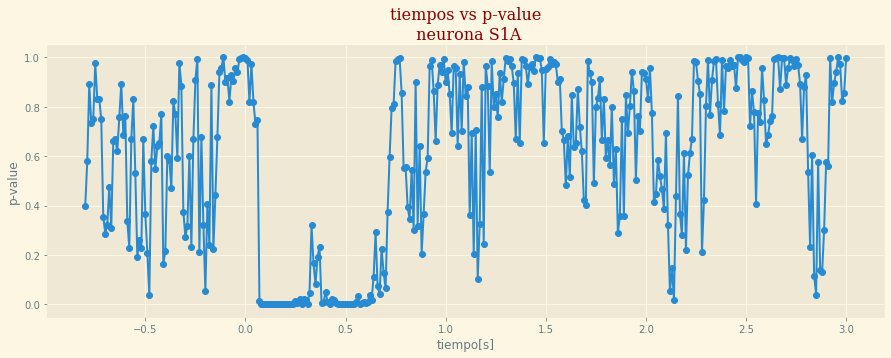

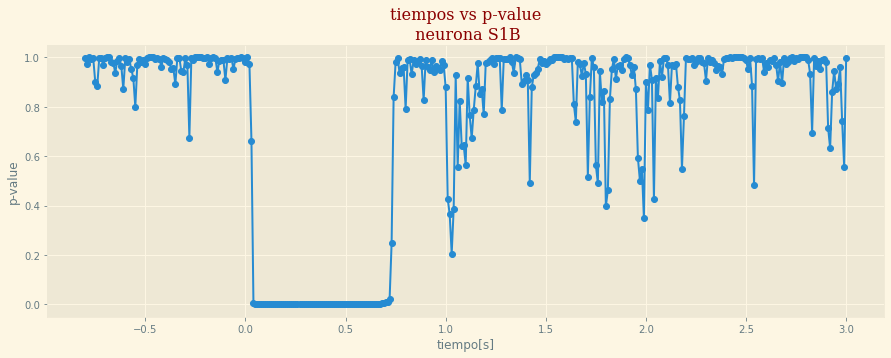

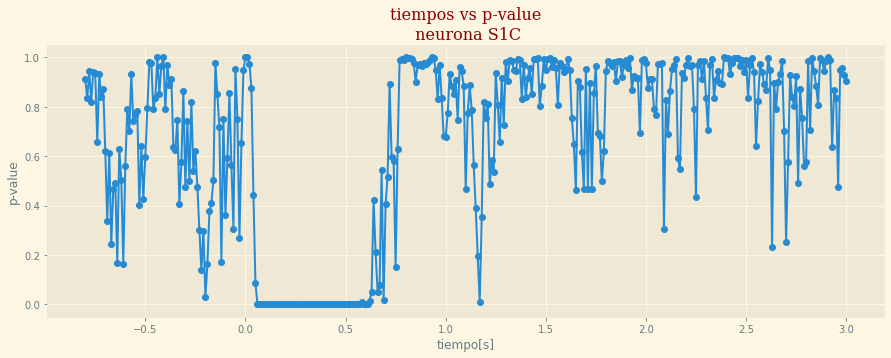

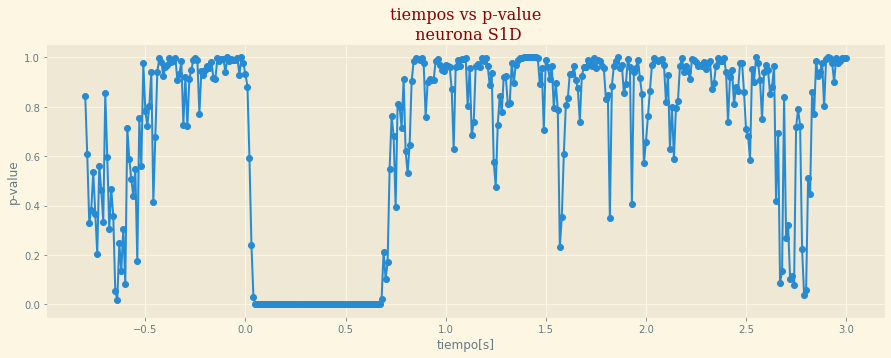

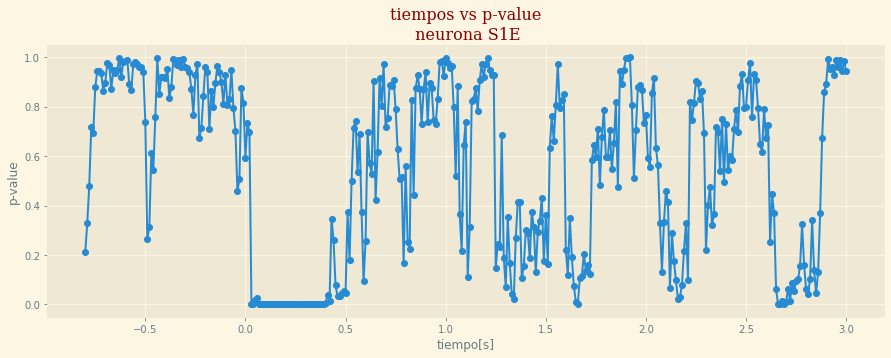

In [162]:
for llave in neuronas:    
    fontdict_title = {'family': 'serif','color':  'darkred','weight': 'normal','size': 16,} # formato para el título
    fig,(ax1)=plt.subplots(nrows=1,ncols=1,sharex=False,figsize=(15,5))
    ax1.scatter(bsup,pes[llave])
    ax1.plot(bsup,pes[llave])
    ax1.set_ylabel('p-value')
    ax1.set_xlabel('tiempo[s]')
    ax1.set_title('tiempos vs p-value\n neurona S1'+llave, fontdict_title) 

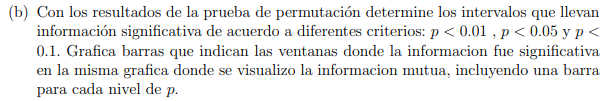

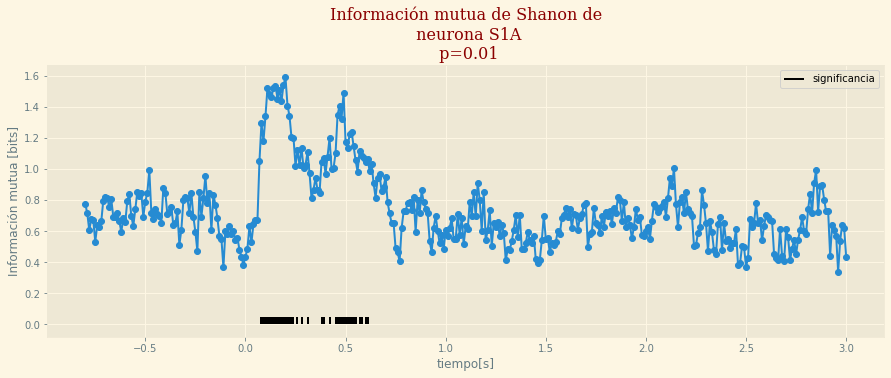

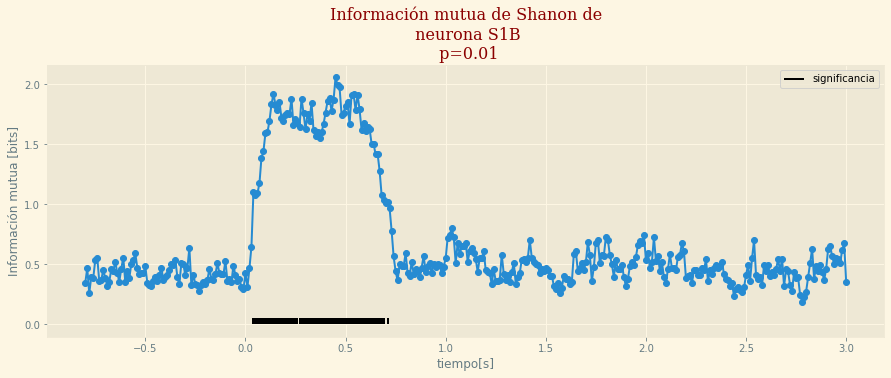

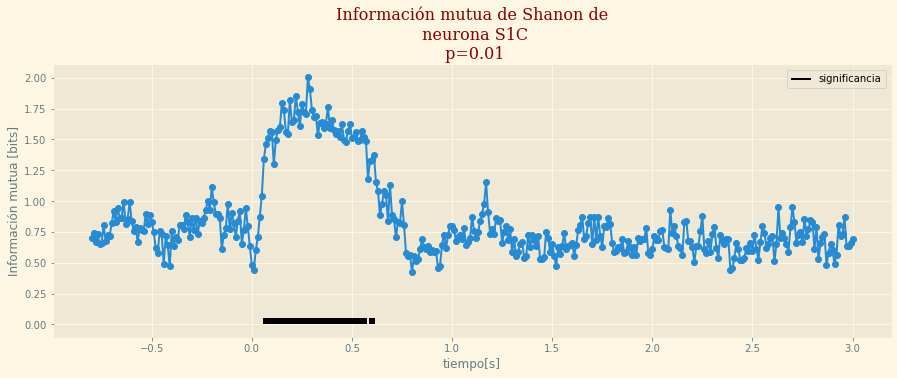

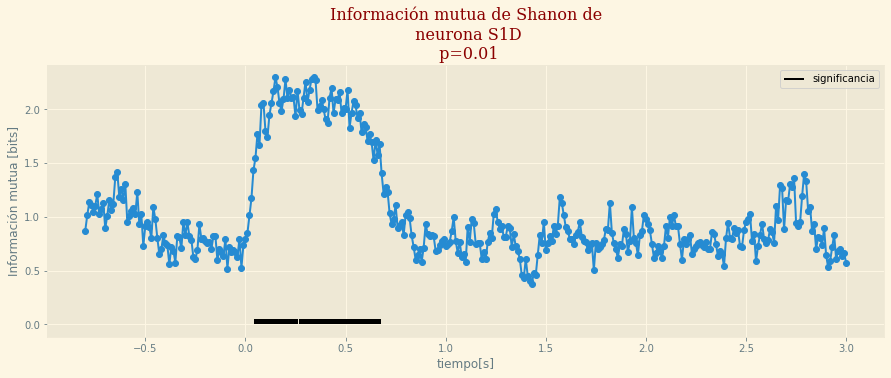

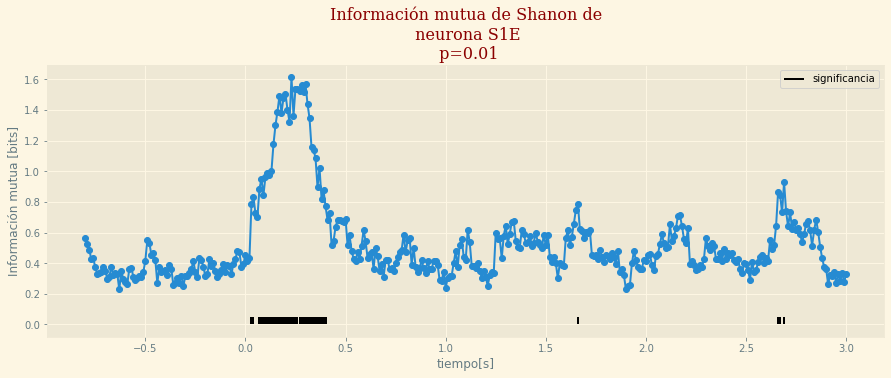

In [216]:
bsup,nven=nrn.bordesup(start=-1,stop=3,paso=0.01,ventana=0.2,nv=True) 
p=0.01
for llave in neuronas:
    Tsignificantes=bsup[np.where(pes[llave]<p)]
    fontdict_title = {'family': 'serif','color':  'darkred','weight': 'normal','size': 16,} # formato para el título
    fig,(ax1)=plt.subplots(nrows=1,ncols=1,sharex=False,figsize=(15,5))
    ax1.scatter(bsup,shanon[llave])
    ax1.plot(bsup,shanon[llave])
    ax1.vlines(Tsignificantes,0,0.05,linestyles ="solid", colors ="k",label='significancia') 
    ax1.set_ylabel('Información mutua [bits]')
    ax1.set_xlabel('tiempo[s]')
    ax1.set_title('Información mutua de Shanon de\n neurona S1'+llave+'\n p='+str(p), fontdict_title)
    ax1.legend()

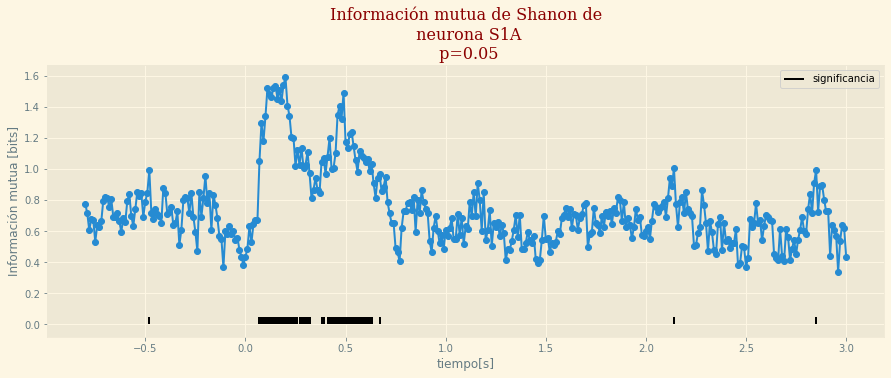

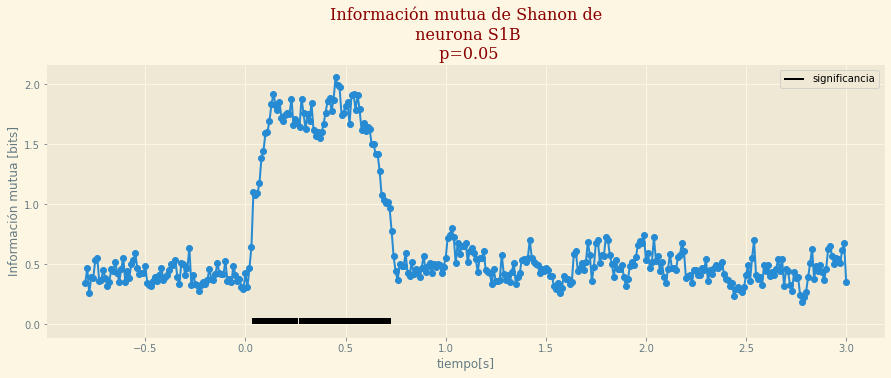

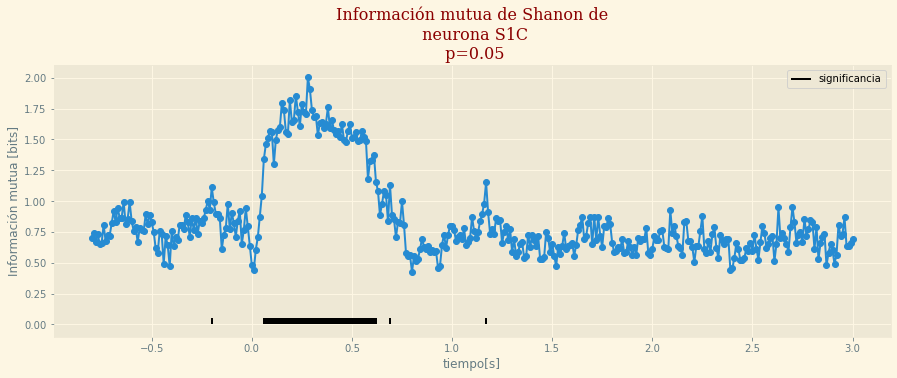

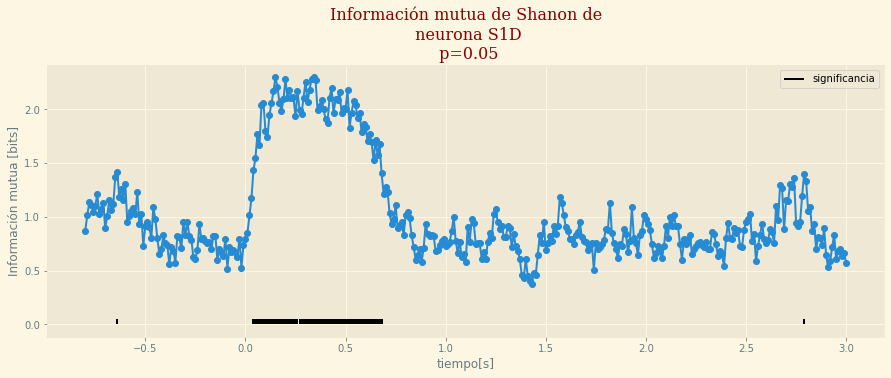

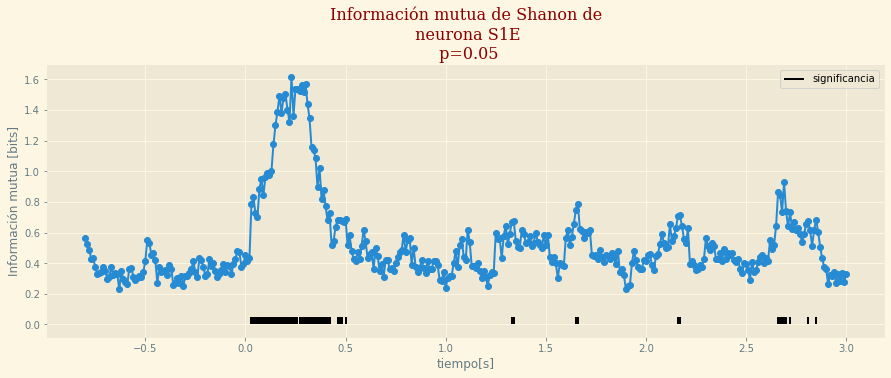

In [217]:
bsup,nven=nrn.bordesup(start=-1,stop=3,paso=0.01,ventana=0.2,nv=True) 
p=0.05
for llave in neuronas:
    Tsignificantes=bsup[np.where(pes[llave]<p)]
    fontdict_title = {'family': 'serif','color':  'darkred','weight': 'normal','size': 16,} # formato para el título
    fig,(ax1)=plt.subplots(nrows=1,ncols=1,sharex=False,figsize=(15,5))
    ax1.scatter(bsup,shanon[llave])
    ax1.plot(bsup,shanon[llave])
    ax1.vlines(Tsignificantes,0,0.05,linestyles ="solid", colors ="k",label='significancia') 
    ax1.set_ylabel('Información mutua [bits]')
    ax1.set_xlabel('tiempo[s]')
    ax1.set_title('Información mutua de Shanon de\n neurona S1'+llave+'\n p='+str(p), fontdict_title)
    ax1.legend()

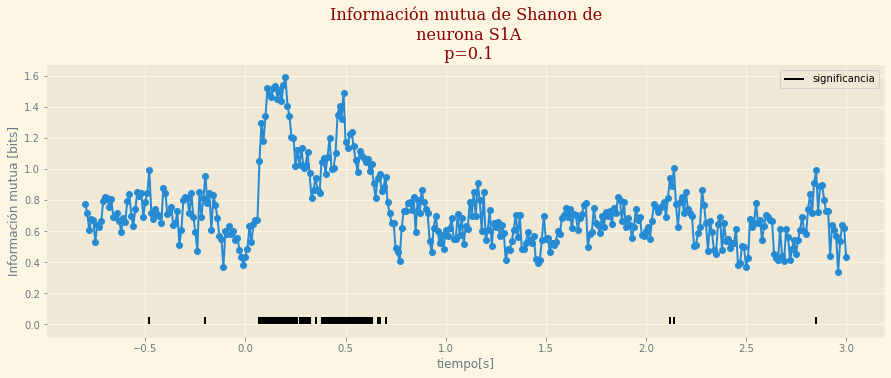

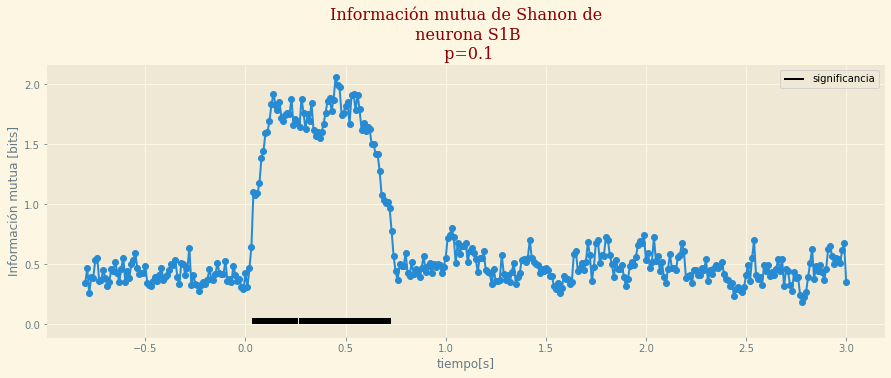

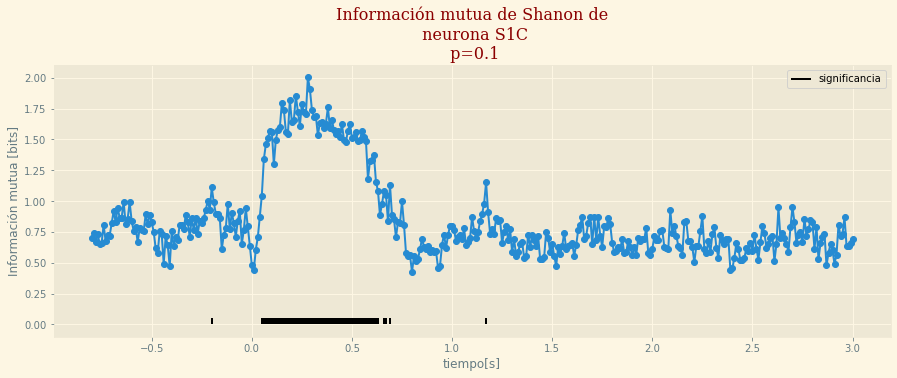

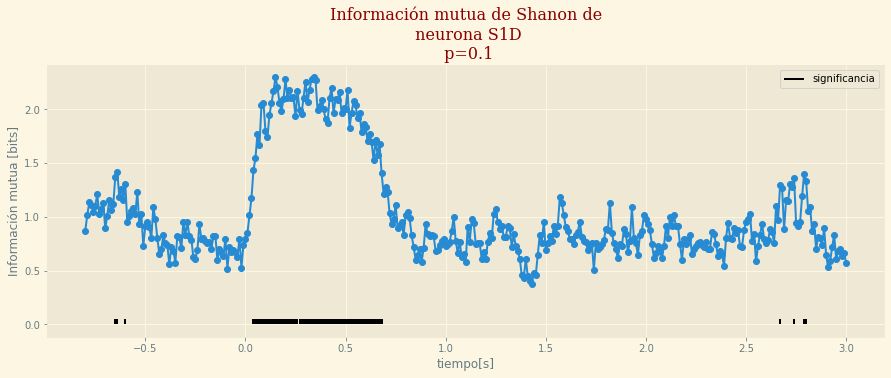

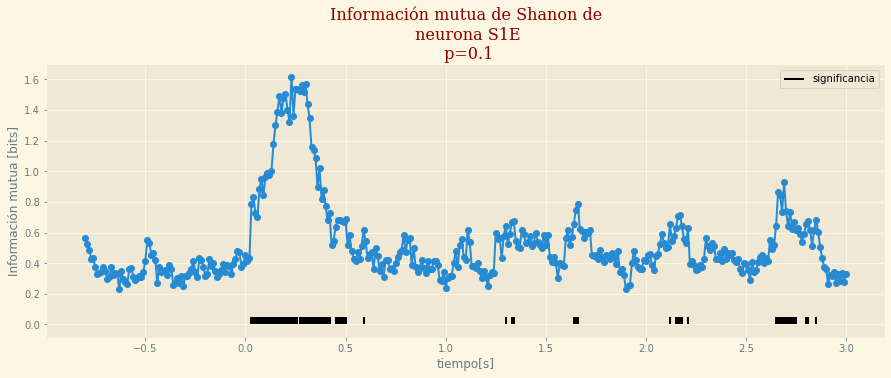

In [218]:
bsup,nven=nrn.bordesup(start=-1,stop=3,paso=0.01,ventana=0.2,nv=True) 
p=0.1
for llave in neuronas:
    Tsignificantes=bsup[np.where(pes[llave]<p)]
    fontdict_title = {'family': 'serif','color':  'darkred','weight': 'normal','size': 16,} # formato para el título
    fig,(ax1)=plt.subplots(nrows=1,ncols=1,sharex=False,figsize=(15,5))
    ax1.scatter(bsup,shanon[llave])
    ax1.plot(bsup,shanon[llave])
    ax1.vlines(Tsignificantes,0,0.05,linestyles ="solid", colors ="k",label='significancia') 
    ax1.set_ylabel('Información mutua [bits]')
    ax1.set_xlabel('tiempo[s]')
    ax1.set_title('Información mutua de Shanon de\n neurona S1'+llave+'\n p='+str(p), fontdict_title)
    ax1.legend()